# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [ ]:
GROUP_NO = 123 # group number
GROUP_MEMBERS = {
    123456: "firstname lastname", # mat. no. : name,
    234567: "firstname lastname",
    345678: "firstname lastname",
}

---

In [ ]:
# required imports
# do not edit!

import asyncio
import itertools
import typing
from datetime import timedelta, datetime

import numpy as np
import pandas as pd

import plotly.express as px
from plotly.graph_objects import FigureWidget

# The streaming_utils.py file has to be in the scripts/ directory next to this notebook
from scripts.streaming_utils import CreationEvent, wiki_stream, EventStreams, Switch, auto_off, run_loop

# Question 5: Big Data (21 pts)

In this section, we will be processing live wikipedia edits in a streaming fashion.
API consumption and event handling are common use-cases for streaming approaches.

The Wikimedia Foundation provides publicly accessible event streams about updates on the wikis and web resources they operate.\
Refer to the following for documentation about the endpoints: [API documentation](https://stream.wikimedia.org/?doc#/streams/get_v2_stream_revision_create).

Some important things to note that hold for the entire task: 
1. We are using some advanced python constructs in the provided code such as asynchronous co-routines. You do not have to understand or adapt such code; simply use the functionality and stay within the `# YOUR CODE HERE` regions.
2. Some pre-implemented code is separated into the file `streaming_utils.py`. You are encouraged to look at it to see how the used methods are defined. For the following imports to work, it has to be in the same directory as this notebook.
3. You do not have to "go beyond" the provided stream objects. When we ask for e.g. "the number of edits", we are always referring to what the `wiki_edits_stream` provides. You do not have to tune the stream settings or filters to somehow attempt to determine what you think is the "true" value.
4. The API wrapper we use here sometimes prints errors (in red) when an API response appears to be incompletely transmitted. This can happen, you do not have to fix this or correct for it; simply ignore it.
5. You can freely edit cells with a `# configuration` comment; you do not have to recreate the initial state. In the same manner, you can create additional cells for your debugging etc. Just make sure to not change the structure of explicit solution cells that contain `# YOUR CODE HERE` or "__Student Answer:__ _your answer here_".

With that out of the way, let's dive in!

## Exploring the Event Stream (0 pts)

Get yourself familiar with the provided utility code that connects to the API and receives all edit and page creation events that occur on wikis operated by the Wikimedia foundation. \
To do so, have a look at the following provided code snippet.
It's a simple processing loop that prints for each event the following information in a readable manner:
- the (wiki) domain
- the edited/created page title
- the username ("user_text") and user account age in days (using "user_registration_dt"), if available
- revision content type and length

This example shows you how to iterate over the event stream using our utility code. The event processing loop runs continuously in the background, however after `AUTO_STOP_TIME`, the loop is automatically terminated to stop infinite loops and breaking the notebook with the huge amount of console output. This variable is used in all tasks and you can edit it as you like for your testing.
You can also manually terminate the background processing with the `Switch` object returned by `run_loop`.
The following code cells show some exemplary usage. Note that this co-routine-based execution swallows exceptions which means your function might raise an exception that does not show up in the notebook console. You can assess whether an exception occurred (e.g., due to a programming mistake) via calling `[your task].exception()` as you can see a few cells below.

In [ ]:
# configuration
AUTO_STOP_TIME = timedelta(seconds=10)

In [ ]:
async def simple_printing(switch: Switch):
    with wiki_stream(streams=['page-create', 'revision-create']) as wiki_edits_stream:
        wiki_edits_stream: EventStreams = wiki_edits_stream
        print('Listening...')

        # `wiki_edits_stream` is a blocking event source
        # that means this for-loop will wait until events arrive from the server
        # that also means it won't terminate on its own, which is why we use the `switch` object (the AUTO_STOP termination uses it too)
        for e in wiki_edits_stream:
            # this check makes sure that we can gracefully stop this endless iteration over future events if the `switch` object's state is toggled `off`
            # the switch object can be manipulated in separate cells, as you can see below
            if switch.off:
                break
            
            change = typing.cast(CreationEvent, e)  # if you have a nice python IDE, this will help with auto-completion
            
            reg_date = change['performer'].get('user_registration_dt')

            age = (pd.Timestamp.now(tz='UTC') - pd.to_datetime(reg_date,
                                                              utc=True)).days if reg_date is not None else 'unknown'
            print(
                f"""Page "{change['page_title']}" on {change['meta']['domain']} edited by {change['performer']['user_text']} (account age: {age} days) details: {change.get('rev_content_model')}:{change.get('rev_len')}""")
            
            # this line is here for technical reasons related to co-routines
            # it is good practice to signal that execution may be paused here, to not excessively hog the CPU
            # you do not have to concern yourself with this; it is always part of the given code skeleton
            await asyncio.sleep(0)

        print('Stopping')

In [ ]:
# run it like this
printing_task, printing_auto_stop_task, printing_switch = run_loop(simple_printing, AUTO_STOP_TIME)

In [ ]:
# check state by printing the task
printing_task

In [ ]:
# stop gracefully
printing_switch.turn_off()

In [ ]:
# stop forcefully
# printing_task.cancel()

In [ ]:
# when the task has terminated, you can explicitly check for a possible exception (just printing the task like above also includes this info)
# when you get no output at all from your code, it's a good idea to take a look at this to debug possible programming errors
# print(printing_task.exception())

## Computing Running Statistics (6.5 pts)

We have learned that storing the entire event stream in memory is often not feasible. Many typical analysis tasks, or in this case, simple statistics, can be reformulated such that they do not require the entire dataset but can make do with a much smaller internal state.

An example is a running (weighted) average. The usual formulation for weights $w_i$ and data points $x_i$ ($i \in \{1,\ldots,N\}$) is
$$\mu = \frac{1}{\sum_{i}w_i} \sum_{i} w_i x_i$$

As a prerequisite for our stream processing, we need a function to compute a running average incrementally.

### a)
Complete the implementation of `compute_running_average` in the following code cell.

_Hint: Notice that calling `compute_running_average` with the weights set to the running stream length $N$ (number of elements condensed into the running average), reduces to $\mathit{compute\_running\_average}(\mu, v, N, 1) = \frac{N}{N+1}\cdot \mu + \frac{1}{N+1} \cdot v$._

In [ ]:
def compute_running_average(running_average: float, new_value: float, running_weight: float, new_weight: float) -> \
        tuple[float, float]:
    """
    Computes the updated running weighted average for new value `new_value`.
    Specifically, returns a tuple of the new running average and new running weight.
    @param running_average intermediate result up to the last element
    @param new_value new element
    @param running_weight accumulated weight up to the last element
    @param new_weight weight of the new element
    @returns (new_running_average, new_running_weight)
    """
    # YOUR CODE HERE


### b)
Describe how this algorithm's space usage scales. Assume $N$ for the length of the stream up to this point and constant space for primitive datatypes like integers, floats, etc. \[in contrast to unbounded numbers that scale logarithmically in size with their value\]. You may use Big $\mathcal{O}$-notation, but you do not have to. \
_Hint: The standard version needs all $w_i$ and $x_i$ values, so $2N$ variables in total. In Big $\mathcal{O}$-notation that is $\mathcal{O}(N)$._

__Student Answer:__ _your answer goes here_

### c)

We can see that there are a lot of edits happening, but can we get some numbers on that? \
**Specifically, in this task, we only care about edits made by non-bot (presumably human) users where the content of the page actually changed due to the revision. Therefore, you have to filter the events that are counted.**

To measure the rate, we want to make use of the running average function implemented in part i) to calculate the number of (filtered) edits per second.

Instead of processing events individually, we use batch processing with a batching interval as configured by `BATCH_INTERVAL`. \
At the end of each batch, the rate of edits should be calculated and incorporated into the running average. Use the true, i.e., measured, duration of the batch as the weight, not the static `BATCH_INTERVAL`.
Both the edit rate within the batch and the overall average should be printed.

The output may look something like this: `[16:05:14.779062] actual batch duration: 5.17s|edits per second: {batch=9.87 | overall=8.33}`.

_Hint: Check the [API documentation](https://stream.wikimedia.org/?doc#/streams/get_v2_stream_revision_create) to find relevant fields._


In [ ]:
# configuration
BATCH_INTERVAL = timedelta(seconds=5)
AUTO_STOP_TIME = timedelta(seconds=30)

In [ ]:
async def edit_rate(switch: Switch):
    with wiki_stream(streams=['page-create', 'revision-create']) as wiki_edits_stream:
        wiki_edits_stream: EventStreams = wiki_edits_stream

        print('Listening...')

        # YOUR CODE HERE
        
        while switch.on:
            print('Starting batch')
            
            # YOUR CODE HERE
            
            print('Finished batch')
            await asyncio.sleep(0)
    print('Stopping...')

In [ ]:
edit_rate_task, edit_rate_auto_stop_task, edit_rate_switch = run_loop(edit_rate, AUTO_STOP_TIME)

In [ ]:
# check state
edit_rate_task

In [ ]:
# manually stop
edit_rate_switch.turn_off()

## Visualizing Streams with Limited Memory Usage (5.5 pts)
To visualize the variability of the edit rate better, we want to continuously update a line plot instead of this endless printed output.\
To not have an unbounded plot size, only the values for the last few updates should be kept in memory.

### d)
Which type of "Streaming Data Range" variant introduced in the lecture does this plotting correspond to?

__Student Answer:__ _your answer goes here_

### e)
Complete the implementation of the method `visualized_edit_rate` (a few cells below) to continuously update the following `FigureWidget` `fw` every `UPDATE_INTERVAL` seconds with the last `UPDATE_HISTORY` measured edit rates.
To do this, adapt the batch-based edit rate algorithm from _c)_. The update interval corresponds to the batching interval. \
**To simplify this task and make it less dependent on _c)_, do not filter the edits here. You also do not need the running average here: only the within-batch edit rates are relevant.**

Do not worry about the figure updating functionality itself, simply use the provided `figure_update_method(time: list[datetime], values: list[float])` in the code skeleton.


In [ ]:
# configuration
UPDATE_HISTORY = 10
UPDATE_INTERVAL = timedelta(seconds=5)

In [ ]:
# recommended to not edit

initialization_dummy = pd.DataFrame([[datetime.now(), 0.0]], columns=['update time', 'edit rate'])
f = px.line(initialization_dummy, x='update time', y='edit rate', markers=True,
            title=f'The running edit rate (last {UPDATE_HISTORY} values)')
f.update_layout(yaxis_title_text='edit rate [1/s]')
fw = FigureWidget(f)

def upd_fw(time: list[datetime], values: list[float]):
    """updates the above created `FigureWidget` fw with `time` and `values` for the x- and y-axis respectively"""
    fw.data[0].x = np.array(time)
    fw.data[0].y = np.array(values)


In [ ]:
fw

For reference, here's what your plot could look like.

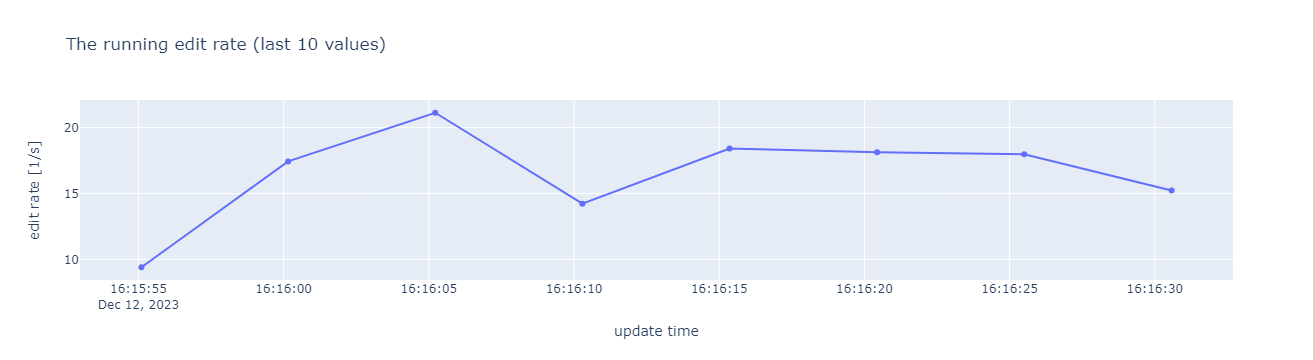

In [ ]:
async def visualized_edit_rate(switch: Switch,
                               figure_update_method: typing.Callable[[list[datetime], list[float]], None]):
    with wiki_stream(streams=['page-create', 'revision-create']) as wiki_edits_stream:
        wiki_edits_stream: EventStreams = wiki_edits_stream
        print('Listening...')
        
        # YOUR CODE HERE
        
        while switch.on:
            print('Starting batch')
            
            # YOUR CODE HERE
            
            print('Finished batch')
            await asyncio.sleep(0)
    print('Stopping...')

In [ ]:
v_edit_rate_task, v_edit_rate_auto_stop_task, v_edit_rate_switch = run_loop(visualized_edit_rate, AUTO_STOP_TIME,
                                                                            figure_update_method=upd_fw)

In [ ]:
# check state
v_edit_rate_task

In [ ]:
# manually stop
v_edit_rate_switch.turn_off()

## Streaming Algorithms (5 pts)

Next, we're going slightly deeper into the context of these edit events.

We want to see which wiki domains receive a lot of updates.
More precisely, for a parameter $k\in\mathbb{N}$ and with $N\in\mathbb{N}$ being the length of the stream up to this point, return all domains that had at least $N/k$ edits. 
This problem is also referred to as _Heavy Hitter Detection_ and belongs to the family of stream summary algorithms.

### a)

Though there are specialized approximate algorithms with probabilistic guarantees out there, we simplify the problem a bit and consider the simple _[Misra-Gries Summary](https://en.wikipedia.org/wiki/Misra%E2%80%93Gries_summary)_.

In pseudocode courtesy of the above-linked Wikipedia page:
```
algorithm misra-gries:[4]
    input: 
        A positive integer k
        A finite sequence s taking values in the range 1,2,...,m
    output: An associative array A with frequency estimates for each item in s
    
    A := new (empty) associative array
    while s is not empty:
        take a value i from s
        if i is in keys(A):
            A[i] := A[i] + 1
        else if |keys(A)| < k - 1:
            A[i] := 1
        else:
            for each K in keys(A):
                A[K] := A[K] - 1
                if A[K] = 0:
                    remove K from keys(A)
    return A
```

Reformulate the above algorithm into our streaming setting using the following code skeleton:


In [ ]:
def update_misra_gries_summary(running_counts: dict[str, int], new_element: str, k: int) -> None:
    """
    Updates `running_counts` in-place according to the Misra-Gries Summary algorithm.
    :param running_counts: a dictionary of running counts - this is the summary
    :param new_element: the next observed element
    :param k: the parameter $k$ that defines the heavy-hitter threshold  
    """
    # YOUR CODE HERE


### b)

Finally, apply your implementation to the edit stream and update the following `FigureWidget` with the current summary of `k` heavy-hitters every `UPDATE_INTERVAL` seconds. 


In [ ]:
# configuration
UPDATE_INTERVAL = timedelta(seconds=5)
k = 10

In [ ]:
# recommended to not edit

initialization_dummy_heavy_hitters = pd.DataFrame([['placeholder', 0]], columns=['domain', 'count'])
f = px.bar(initialization_dummy_heavy_hitters, x='domain', y='count', title=f'The k={k} heavy-hitter domains')

fw_heavy_hitters = FigureWidget(f)

def upd_fw_heavy_hitters(summary: dict[str, int]) -> None:
    elements, counts = list(zip(*summary.items()))
    sorted_idx = np.argsort(counts)[::-1]

    fw_heavy_hitters.data[0].x = np.take(elements, sorted_idx)
    fw_heavy_hitters.data[0].y = np.take(counts, sorted_idx)


In [ ]:
fw_heavy_hitters

For reference, here's what your plot could look like.

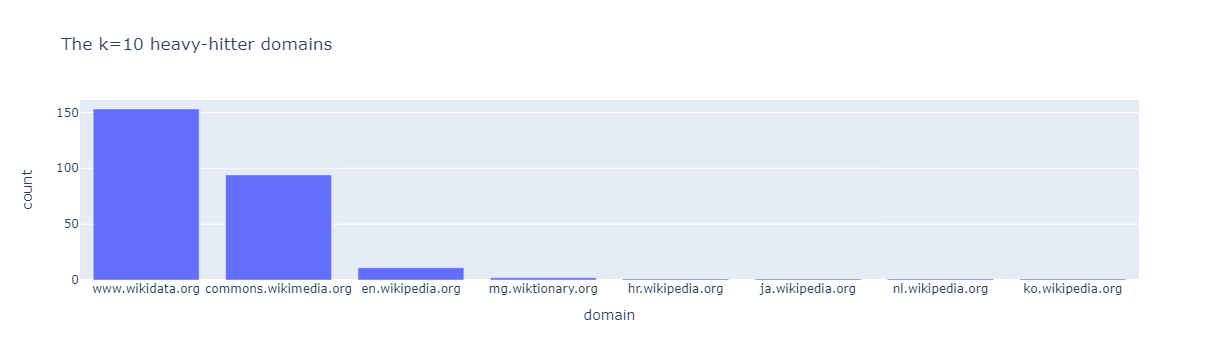

In [ ]:
async def heavy_hitters(switch: Switch, k_heavy_hitters_update_method: typing.Callable[[dict[str, int], str, int], None],
                        figure_update_method: typing.Callable[[dict[str, int]], None]):
    with wiki_stream(streams=['page-create', 'revision-create']) as wiki_edits_stream:
        wiki_edits_stream: EventStreams = wiki_edits_stream

        print('Listening...')

        # YOUR CODE HERE
        
        while switch.on:
            for e in wiki_edits_stream:
                change = typing.cast(CreationEvent, e)
                
                # YOUR CODE HERE

            await asyncio.sleep(0) # do not change!
    print('Stopping...')

In [ ]:
heavy_hitters_task, heavy_hitters_auto_stop_task, heavy_hitters_switch = run_loop(heavy_hitters, AUTO_STOP_TIME,
                                                                                  k_heavy_hitters_update_method=update_misra_gries_summary,
                                                                                  figure_update_method=upd_fw_heavy_hitters)

In [ ]:
# check state
heavy_hitters_task

In [ ]:
# manually stop
heavy_hitters_switch.turn_off()

## Heavy-Hitters via Map-Reduce (4pts)
As a thought experiment, let's assume that instead of this approximation you wanted to calculate the exact heavy hitters and were ready to save the streamed data (over a certain time frame) to disk.\
Specifically, we want to consider how these k-heavy-hitters could be computed in a **Map-Reduce** fashion with the data stored in a HDFS.

To warm up, take a look at the following example as a way to structure and express a sequence of map-reduce tasks. Read this thoroughly, so that you can answer the next question properly. Note that though we use python code combined with pseudo-code/comments, the cell is not intended to be executed in this notebook. It is merely to describe the functions as precisely as possible without requiring an extensive technical setup.

Some more details:
Recall the map/reduce definitions presented in the lecture.
$$
\begin{align*}
\mathit{map} &\in K_1 \times V_1 \to (K_2 \times V_2)^* \\
\mathit{reduce} &\in K_2 \times (V_2)^* \to (K_3 \times V_3)^*
\end{align*}
$$

We extend them slightly _with context_ to make them more practical and match the reality of Hadoop Map-Reduce programming.
$$
\begin{align*}
\mathit{map} &\in \mathit{Context} \times (K_1 \times V_1) \to (K_2 \times V_2)^* \\
\mathit{reduce} &\in \mathit{Context} \times (K_2 \times (V_2)^*) \to (K_3 \times V_3)^*
\end{align*}
$$
where $Context$ is a constant size dictionary that allows you to pass in a fixed number of arguments into your functions.

Additionally, we specifiy the input and output files for each map-reduce stage. The files are also merely symbolic: they are not actual files to be created.

The following cell contains a simple example that raises numbers (keyed by an integer index) to a parameterized value that is followed by a summation over all indices.
Note the correspondence of the function signatures to the mathematical definitions. You can use `str` (strings) and `int` (integers) as key/value domains ($K_i, V_j, \ldots$).

In [ ]:
# describe file(s) you need
# note that these files are merely symbolical, they are not required to be required as this is not executable code
# "their typing" is just illustrative
# distributed file vector.txt: list[tuple[int, int]]
# contains tuples (i, x): tuple[int, int] where i is an index, and x an integer

# distributed file intermediate.txt: list[tuple[str, int]]
# distributed file result.txt: list[tuple[str, int]]

# describe how the context would have to be initialized. This does not have to be a concrete value; it just has be known/computed beforehand.
Context = {}
Context['n'] = 2 

# note this function signature's equivalence to $\mathit{map_1} \in \mathit{Context} \times (int \times int) \to (int \times int)^*$
def map_1(Context, key_value_pair: tuple[int, int]) -> list[tuple[int, int]]:
    k, v = key_value_pair
    return [(k, v)]

def reduce_1(Context, key_values_pair: tuple[int, list[int]]) -> list[tuple[int, int]]:
    k, vs = key_values_pair
    # if we assume unique indices, this summation is superflous; there's only ever exactly one value in each list
    return [(k, sum(v ** Context['n'] for v in vs))]

# run (map_1, reduce_1) with input vector.txt and output intermediate.txt
# intermediate.txt now contains pairs of (i, $x^n$): tuple[int, int] 

def map_2(Context, key_value_pair: tuple[int, int]) -> list[tuple[str, int]]:
    k, v = key_value_pair
    return [('result', v)]

def reduce_2(Context, key_values_pair: tuple[str, list[int]]) -> list[tuple[str, int]]:
    k, vs = key_values_pair
    return [('result', sum(v for v in vs))]

# run (map_2, reduce_2) with input intermediate.txt and output result.txt

# result.txt now contains just one key-value pair: ('result', $\sum_i x_i^n$): tuple[str, int]
# if you had another stage of map-reduce, you could assign it to the context (pseudo-code) as follows
# ('result', value) = result.txt
# Context['res'] = value
# there is no rigorous syntax to use here, just make sure to be clear and do not make any computations here

### a)

Now that we've warmed up:

Assume that the domains are simply stored along with their recording time (irrelevant here) as the key.\
$k$ is known and present in your context, i.e., `Context['k'] = k`. \
Consider the situation in which you do not know how many events $N$ were processed, i.e., $N$ **is unknown a-priori**.

**Describe the map-reduce stages you need to eventually determine the $k$ heavy-hitter domains. Use the same code + pseudo-code style as above.**

The initial input is:
```
# distributed file domains.txt: list[tuple[str, str]]
# contains tuples (t, d): tuple[str, str] where t is the irrelevant key (as a string), and d is a domain name
```


In [ ]:
# YOUR CODE HERE